# Import libraries

The required libraries for this notebook are imported as follows:

In [95]:
# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.svm import SVC
from sklearn.metrics import classification_report,accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV, train_test_split, learning_curve, ShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from sklearn.decomposition import PCA
from skimage.feature import hog
import datetime as dt
import pandas as pd
import os
from skimage.io import imread, imshow


# Load the data

In [34]:
# Path to all images
basedir = './dataset'
images_dir = os.path.join(basedir,'image')
labels_filename = 'label.csv'

# Extracting Features and Labels for Each Image

In [35]:
# Creating an array of image paths inside the /dataset/image directory
image_paths = [os.path.join(images_dir, l) for l in os.listdir(images_dir)]
target_size = None

# Opening the'label.csv' document 
labels_file = open(os.path.join(basedir, labels_filename), 'r')

# Reading the lines
lines = labels_file.readlines()

# Splitting the labels with the corresponding image
tumor_labels = {line.split(',')[0] : (line.split(',')[1]) for line in lines[1:]}

# Assigning the value of 0 for the no_tumor labes and 1 for the rest
for i in tumor_labels:
    tumor_labels[i] = tumor_labels[i].replace('\n', '')
    if tumor_labels[i] == "no_tumor":
        tumor_labels[i] = 0
    else:
        tumor_labels[i] = 1
        
print(tumor_labels)    

{'IMAGE_0000.jpg': 1, 'IMAGE_0001.jpg': 0, 'IMAGE_0002.jpg': 1, 'IMAGE_0003.jpg': 1, 'IMAGE_0004.jpg': 1, 'IMAGE_0005.jpg': 1, 'IMAGE_0006.jpg': 0, 'IMAGE_0007.jpg': 1, 'IMAGE_0008.jpg': 1, 'IMAGE_0009.jpg': 1, 'IMAGE_0010.jpg': 1, 'IMAGE_0011.jpg': 1, 'IMAGE_0012.jpg': 1, 'IMAGE_0013.jpg': 1, 'IMAGE_0014.jpg': 1, 'IMAGE_0015.jpg': 1, 'IMAGE_0016.jpg': 1, 'IMAGE_0017.jpg': 1, 'IMAGE_0018.jpg': 1, 'IMAGE_0019.jpg': 0, 'IMAGE_0020.jpg': 0, 'IMAGE_0021.jpg': 1, 'IMAGE_0022.jpg': 1, 'IMAGE_0023.jpg': 1, 'IMAGE_0024.jpg': 1, 'IMAGE_0025.jpg': 1, 'IMAGE_0026.jpg': 1, 'IMAGE_0027.jpg': 0, 'IMAGE_0028.jpg': 1, 'IMAGE_0029.jpg': 1, 'IMAGE_0030.jpg': 1, 'IMAGE_0031.jpg': 1, 'IMAGE_0032.jpg': 1, 'IMAGE_0033.jpg': 1, 'IMAGE_0034.jpg': 1, 'IMAGE_0035.jpg': 1, 'IMAGE_0036.jpg': 0, 'IMAGE_0037.jpg': 1, 'IMAGE_0038.jpg': 1, 'IMAGE_0039.jpg': 1, 'IMAGE_0040.jpg': 1, 'IMAGE_0041.jpg': 1, 'IMAGE_0042.jpg': 0, 'IMAGE_0043.jpg': 1, 'IMAGE_0044.jpg': 1, 'IMAGE_0045.jpg': 1, 'IMAGE_0046.jpg': 1, 'IMAGE_0047.

## Test data

In [36]:
basedir2 = './test'
images_dir2 = os.path.join(basedir2,'image')
labels_filename = 'label.csv'
# Creating an array of image paths inside the /test/image directory
image_paths2 = [os.path.join(images_dir2, l) for l in os.listdir(images_dir2)]
target_size = None

# Opening the'label.csv' document 
labels_file2 = open(os.path.join(basedir2, labels_filename), 'r')

# Reading the lines
lines2 = labels_file2.readlines()

# Splitting the labels with the corresponding image
tumor_labels2 = {line.split(',')[0] : (line.split(',')[1]) for line in lines2[1:]}

# Assigning the value of 0 for the no_tumor labes and 1 for the rest
for i in tumor_labels2:
    tumor_labels2[i] = tumor_labels2[i].replace('\n', '')
    if tumor_labels2[i] == "no_tumor":
        tumor_labels2[i] = 0
    else:
        tumor_labels2[i] = 1
               
print(tumor_labels)   

{'IMAGE_0000.jpg': 1, 'IMAGE_0001.jpg': 0, 'IMAGE_0002.jpg': 1, 'IMAGE_0003.jpg': 1, 'IMAGE_0004.jpg': 1, 'IMAGE_0005.jpg': 1, 'IMAGE_0006.jpg': 0, 'IMAGE_0007.jpg': 1, 'IMAGE_0008.jpg': 1, 'IMAGE_0009.jpg': 1, 'IMAGE_0010.jpg': 1, 'IMAGE_0011.jpg': 1, 'IMAGE_0012.jpg': 1, 'IMAGE_0013.jpg': 1, 'IMAGE_0014.jpg': 1, 'IMAGE_0015.jpg': 1, 'IMAGE_0016.jpg': 1, 'IMAGE_0017.jpg': 1, 'IMAGE_0018.jpg': 1, 'IMAGE_0019.jpg': 0, 'IMAGE_0020.jpg': 0, 'IMAGE_0021.jpg': 1, 'IMAGE_0022.jpg': 1, 'IMAGE_0023.jpg': 1, 'IMAGE_0024.jpg': 1, 'IMAGE_0025.jpg': 1, 'IMAGE_0026.jpg': 1, 'IMAGE_0027.jpg': 0, 'IMAGE_0028.jpg': 1, 'IMAGE_0029.jpg': 1, 'IMAGE_0030.jpg': 1, 'IMAGE_0031.jpg': 1, 'IMAGE_0032.jpg': 1, 'IMAGE_0033.jpg': 1, 'IMAGE_0034.jpg': 1, 'IMAGE_0035.jpg': 1, 'IMAGE_0036.jpg': 0, 'IMAGE_0037.jpg': 1, 'IMAGE_0038.jpg': 1, 'IMAGE_0039.jpg': 1, 'IMAGE_0040.jpg': 1, 'IMAGE_0041.jpg': 1, 'IMAGE_0042.jpg': 0, 'IMAGE_0043.jpg': 1, 'IMAGE_0044.jpg': 1, 'IMAGE_0045.jpg': 1, 'IMAGE_0046.jpg': 1, 'IMAGE_0047.

In [37]:
def extract_features_labels():
    if os.path.isdir(images_dir):
        all_features = []
        all_labels = []
        for img_path in image_paths:
            file_name = img_path.split('\\')[-1] # If using macOS, one should change the "\\" to "/"  

            # loading image and setting the as_gray parameter of imread set to True to combine
            # the color channels from the images into a single grayscale representation of luminance
            img = imread(img_path, as_gray = True)
            
            # Converting the two dimensional features into one dimension
            features = np.reshape(img, (512,512,1))
            
            # Storing the pixel information of the images in the all_features array
            # and their labels in the all_labels array
            if features is not None:
                all_features.append(features)
                all_labels.append(tumor_labels[file_name])
        
        # For test data
        all_features2 = []
        all_labels2 = []
        for img_path in image_paths2:
            file_name = img_path.split('\\')[-1] # If using macOS, one should change the "\\" to "/"  

            # loading image and setting the as_gray parameter of imread set to True to combine
            # the color channels from the images into a single grayscale representation of luminance
            img = imread(img_path, as_gray = True)
            
            # Converting the two dimensional features into one dimension
            features = np.reshape(img, (512,512,1))
            
            # Storing the pixel information of the images in the all_features array
            # and their labels in the all_labels array
            if features is not None:
                all_features2.append(features)
                all_labels2.append(tumor_labels2[file_name])

    # Converting them to numpy arrays            
    np_features = np.array(all_features)
    np_labels = np.array(all_labels)
    np_features2 = np.array(all_features2)
    np_labels2 = np.array(all_labels2)
    
    return np_features, np_labels, np_features2, np_labels2

# Preparing the training and test set

In [38]:
# Splitting the data into training and test set
X, y, X2, y2 = extract_features_labels()

In [39]:
X.shape

(3000, 512, 512, 1)

In [40]:
range(len(X))

range(0, 3000)

In [41]:
hog_visu = []
hog_X = []
for image in range(len(X)):
    x, visu = hog(X[image], orientations=9, pixels_per_cell=(16,16),cells_per_block=(1, 1), visualize = True)
    hog_visu.append(visu)
    hog_X.append(x)

## Test

In [42]:
hog_visu2 = []
hog_X2 = []
for image in range(len(X2)):
    x, visu = hog(X2[image], orientations=9, pixels_per_cell=(16,16),cells_per_block=(1, 1), visualize = True)
    hog_visu2.append(visu)
    hog_X2.append(x)

In [43]:
hog_X = np.array(hog_X)
hog_X.shape

(3000, 9216)

In [46]:
hog_X = np.array(hog_X)
hog_X.shape

(3000, 9216)

In [47]:
scale = StandardScaler()
scale.fit(hog_X)
scale_X = scale.transform(hog_X)
pca = PCA(.85)
pca.fit(scale_X)
pca_X = pca.transform(scale_X)

In [48]:
#scale = StandardScaler()
scale.fit(hog_X2)
scale_X2 = scale.transform(hog_X2)
#pca = PCA(.85)
#pca.fit(scale_X)
pca_X2 = pca.transform(scale_X2)

In [49]:
pca.n_components_

886

In [50]:
pca_X2.shape

(200, 886)

In [52]:
x_train, x_test, y_train, y_test = train_test_split(pca_X, y, train_size=0.8, random_state=10)

# Using SVM from a library

In [71]:
model = SVC()
# Defining the parameter grid that is comprised of different parameter combinations
param_grid = {'C': [0.01, 0.1, 1, 10],
              'gamma': [0.0001, 0.001, 0.01],
              'kernel': ['rbf', 'linear', 'poly'],
             }
                    
# Apply GridSearchCV to find best parameters for given dataset
# verbose is used to describe the steps taken to find best parameters
cv = GridSearchCV(model, param_grid, refit = True,verbose= 3) 
cv.fit(x_train,y_train)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
[CV 1/5] END ..C=0.01, gamma=0.0001, kernel=rbf;, score=0.848 total time=   0.5s
[CV 2/5] END ..C=0.01, gamma=0.0001, kernel=rbf;, score=0.848 total time=   0.5s
[CV 3/5] END ..C=0.01, gamma=0.0001, kernel=rbf;, score=0.848 total time=   0.5s
[CV 4/5] END ..C=0.01, gamma=0.0001, kernel=rbf;, score=0.846 total time=   0.5s
[CV 5/5] END ..C=0.01, gamma=0.0001, kernel=rbf;, score=0.846 total time=   0.5s
[CV 1/5] END C=0.01, gamma=0.0001, kernel=linear;, score=0.956 total time=   0.2s
[CV 2/5] END C=0.01, gamma=0.0001, kernel=linear;, score=0.948 total time=   0.2s
[CV 3/5] END C=0.01, gamma=0.0001, kernel=linear;, score=0.954 total time=   0.2s
[CV 4/5] END C=0.01, gamma=0.0001, kernel=linear;, score=0.960 total time=   0.2s
[CV 5/5] END C=0.01, gamma=0.0001, kernel=linear;, score=0.963 total time=   0.2s
[CV 1/5] END .C=0.01, gamma=0.0001, kernel=poly;, score=0.848 total time=   0.6s
[CV 2/5] END .C=0.01, gamma=0.0001, kernel

[CV 2/5] END ....C=1, gamma=0.0001, kernel=poly;, score=0.919 total time=   1.0s
[CV 3/5] END ....C=1, gamma=0.0001, kernel=poly;, score=0.915 total time=   0.9s
[CV 4/5] END ....C=1, gamma=0.0001, kernel=poly;, score=0.931 total time=   0.9s
[CV 5/5] END ....C=1, gamma=0.0001, kernel=poly;, score=0.931 total time=   0.9s
[CV 1/5] END ......C=1, gamma=0.001, kernel=rbf;, score=0.921 total time=   1.6s
[CV 2/5] END ......C=1, gamma=0.001, kernel=rbf;, score=0.908 total time=   1.7s
[CV 3/5] END ......C=1, gamma=0.001, kernel=rbf;, score=0.900 total time=   1.6s
[CV 4/5] END ......C=1, gamma=0.001, kernel=rbf;, score=0.910 total time=   1.6s
[CV 5/5] END ......C=1, gamma=0.001, kernel=rbf;, score=0.906 total time=   1.6s
[CV 1/5] END ...C=1, gamma=0.001, kernel=linear;, score=0.956 total time=   0.2s
[CV 2/5] END ...C=1, gamma=0.001, kernel=linear;, score=0.948 total time=   0.2s
[CV 3/5] END ...C=1, gamma=0.001, kernel=linear;, score=0.954 total time=   0.2s
[CV 4/5] END ...C=1, gamma=0

GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.01, 0.1, 1, 10],
                         'gamma': [0.0001, 0.001, 0.01],
                         'kernel': ['rbf', 'linear', 'poly']},
             verbose=3)

In [72]:
# Display parameters selected by GridSearchCV for SVM 3 classes
# Parameters obtained: {'C': 10, 'gamma': 0.0001, 'kernel': 'rbf'}
print("Best parameters to apply are:",cv.best_params_)
# Display model after hyperparameter tuning
svm = cv.best_estimator_
print("Model after tuning is:\n",svm)

Best parameters to apply are: {'C': 0.01, 'gamma': 0.0001, 'kernel': 'linear'}
Model after tuning is:
 SVC(C=0.01, gamma=0.0001, kernel='linear')


In [73]:
param2_grid = {'C': [0.001, 0.003, 0.006, 0.01, 0.02, 0.05],
              'gamma': [0.0005, 0.0001, 0.00005, 0.00001],
              'kernel': ['rbf','linear'],
             }

cv2 = GridSearchCV(model, param2_grid, refit = True,verbose= 3) 
cv2.fit(x_train,y_train)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
[CV 1/5] END .C=0.001, gamma=0.0005, kernel=rbf;, score=0.848 total time=   0.6s
[CV 2/5] END .C=0.001, gamma=0.0005, kernel=rbf;, score=0.848 total time=   0.6s
[CV 3/5] END .C=0.001, gamma=0.0005, kernel=rbf;, score=0.848 total time=   0.6s
[CV 4/5] END .C=0.001, gamma=0.0005, kernel=rbf;, score=0.846 total time=   0.6s
[CV 5/5] END .C=0.001, gamma=0.0005, kernel=rbf;, score=0.846 total time=   0.6s
[CV 1/5] END C=0.001, gamma=0.0005, kernel=linear;, score=0.956 total time=   0.2s
[CV 2/5] END C=0.001, gamma=0.0005, kernel=linear;, score=0.946 total time=   0.2s
[CV 3/5] END C=0.001, gamma=0.0005, kernel=linear;, score=0.954 total time=   0.2s
[CV 4/5] END C=0.001, gamma=0.0005, kernel=linear;, score=0.958 total time=   0.2s
[CV 5/5] END C=0.001, gamma=0.0005, kernel=linear;, score=0.965 total time=   0.2s
[CV 1/5] END .C=0.001, gamma=0.0001, kernel=rbf;, score=0.848 total time=   0.5s
[CV 2/5] END .C=0.001, gamma=0.0001, 

[CV 1/5] END ..C=0.006, gamma=5e-05, kernel=rbf;, score=0.848 total time=   0.6s
[CV 2/5] END ..C=0.006, gamma=5e-05, kernel=rbf;, score=0.848 total time=   0.5s
[CV 3/5] END ..C=0.006, gamma=5e-05, kernel=rbf;, score=0.848 total time=   0.6s
[CV 4/5] END ..C=0.006, gamma=5e-05, kernel=rbf;, score=0.846 total time=   0.6s
[CV 5/5] END ..C=0.006, gamma=5e-05, kernel=rbf;, score=0.846 total time=   0.6s
[CV 1/5] END C=0.006, gamma=5e-05, kernel=linear;, score=0.956 total time=   0.2s
[CV 2/5] END C=0.006, gamma=5e-05, kernel=linear;, score=0.948 total time=   0.2s
[CV 3/5] END C=0.006, gamma=5e-05, kernel=linear;, score=0.954 total time=   0.2s
[CV 4/5] END C=0.006, gamma=5e-05, kernel=linear;, score=0.960 total time=   0.2s
[CV 5/5] END C=0.006, gamma=5e-05, kernel=linear;, score=0.963 total time=   0.2s
[CV 1/5] END ..C=0.006, gamma=1e-05, kernel=rbf;, score=0.848 total time=   0.5s
[CV 2/5] END ..C=0.006, gamma=1e-05, kernel=rbf;, score=0.848 total time=   0.5s
[CV 3/5] END ..C=0.006,

[CV 2/5] END ..C=0.05, gamma=0.0005, kernel=rbf;, score=0.848 total time=   1.4s
[CV 3/5] END ..C=0.05, gamma=0.0005, kernel=rbf;, score=0.848 total time=   1.4s
[CV 4/5] END ..C=0.05, gamma=0.0005, kernel=rbf;, score=0.846 total time=   1.4s
[CV 5/5] END ..C=0.05, gamma=0.0005, kernel=rbf;, score=0.846 total time=   1.4s
[CV 1/5] END C=0.05, gamma=0.0005, kernel=linear;, score=0.956 total time=   0.2s
[CV 2/5] END C=0.05, gamma=0.0005, kernel=linear;, score=0.948 total time=   0.2s
[CV 3/5] END C=0.05, gamma=0.0005, kernel=linear;, score=0.954 total time=   0.2s
[CV 4/5] END C=0.05, gamma=0.0005, kernel=linear;, score=0.960 total time=   0.2s
[CV 5/5] END C=0.05, gamma=0.0005, kernel=linear;, score=0.963 total time=   0.2s
[CV 1/5] END ..C=0.05, gamma=0.0001, kernel=rbf;, score=0.848 total time=   0.6s
[CV 2/5] END ..C=0.05, gamma=0.0001, kernel=rbf;, score=0.848 total time=   0.6s
[CV 3/5] END ..C=0.05, gamma=0.0001, kernel=rbf;, score=0.848 total time=   0.6s
[CV 4/5] END ..C=0.05, 

GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.001, 0.003, 0.006, 0.01, 0.02, 0.05],
                         'gamma': [0.0005, 0.0001, 5e-05, 1e-05],
                         'kernel': ['rbf', 'linear']},
             verbose=3)

In [74]:
# Display parameters selected by GridSearchCV for SVM 3 classes
# Parameters obtained: {'C': 10, 'gamma': 0.0001, 'kernel': 'rbf'}
print("Best parameters to apply are:",cv2.best_params_)
# Display model after hyperparameter tuning
svm2 = cv2.best_estimator_
print("Model after tuning is:\n",svm2)

Best parameters to apply are: {'C': 0.003, 'gamma': 0.0005, 'kernel': 'linear'}
Model after tuning is:
 SVC(C=0.003, gamma=0.0005, kernel='linear')


In [75]:
# Predict the output of model after above parameters are applied to it
y_prediction = svm2.predict(x_test)
y_prediction2 = svm2.predict(pca_X2)

In [76]:
# Print expected and predicted output
print("Expected results: ",y_test)
print("Predicted results:",y_prediction)

Expected results:  [1 1 1 1 1 0 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 0 1 0 1 1 1 0 1 1 1 1 0 1 1 1 1 1 1 1 1 1 0 1 0 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 0 0 1 0 1 1 1 1 0 1 1 0
 1 1 1 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 1 1 0 1 0 1 1 0 1 1
 1 0 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 0 1 0 1 1 1 1 1 0 1 1
 0 1 1 1 1 0 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 1 1 1 1 1 1
 1 1 1 1 0 1 1 1 0 1 1 1 1 0 1 1 1 0 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1
 1 0 1 1 1 1 1 1 0 1 0 1 1 1 0 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1
 1 1 1 0 1 0 0 1 1 1 1 1 1 1 0 0 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 0 1 1 0 1 1 1 0 1 1 1
 1 1 1 0 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 0 1 1 1 1 1 0
 1 1 1

In [77]:
print("Accuracy:", accuracy_score(y_test, y_prediction))

Accuracy: 0.9666666666666667


In [78]:
print("Accuracy:", accuracy_score(y2, y_prediction2))

Accuracy: 0.945


# Creating a classification report

In [79]:
target_names = ['Patient without Tumor', 'Patient with Tumor']
print(classification_report(y_test, y_prediction, target_names=target_names))
print(classification_report(y2, y_prediction2, target_names=target_names))

                       precision    recall  f1-score   support

Patient without Tumor       0.91      0.85      0.88        87
   Patient with Tumor       0.97      0.99      0.98       513

             accuracy                           0.97       600
            macro avg       0.94      0.92      0.93       600
         weighted avg       0.97      0.97      0.97       600

                       precision    recall  f1-score   support

Patient without Tumor       0.96      0.73      0.83        37
   Patient with Tumor       0.94      0.99      0.97       163

             accuracy                           0.94       200
            macro avg       0.95      0.86      0.90       200
         weighted avg       0.95      0.94      0.94       200



# Visualizing the confusion matrix 

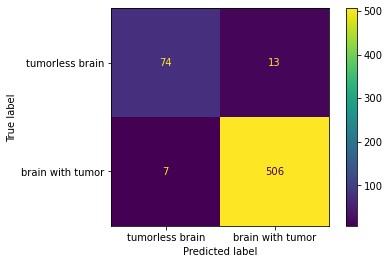

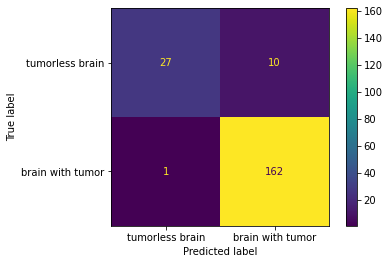

In [88]:
cm = confusion_matrix(y_test, y_prediction)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['tumorless brain', 'brain with tumor'])
disp.plot()
cm2 = confusion_matrix(y2, y_prediction2)
disp2 = ConfusionMatrixDisplay(confusion_matrix=cm2, display_labels=['tumorless brain', 'brain with tumor'])
disp2.plot()

In [ ]:
#, labels=model.classes_
#, display_labels=model.classes_